# Analysing CPPI Strategies Interactively
Portfolio risk management using diligent asset allocation strategy to limit downside risk   
*by Chee-Foong on 24 Nov 2020*  

---

## Summary
This is an interactive notebook to study and analyse the CPPI strategies in details.  Specifically, using simulated risky asset returns and observe the risk and performance of the CPPI portfolio.  For example, how various parameters affect the portfolio statistics like volatility and maximum drawdown.  In addition, we will also explore how potentially one should calibrate the multipler to minimise the number of violations (asset values dropping below the floor).

## Reference
Course Materials and Projects of [Investment Management with Python & Machine Learning](https://online.edhec.edu/en/online-programmes/data-science-and-machine-learning-for-asset-management/) Course


## Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

import sys  
sys.path.append('../src') 
from edge_risk_kit import *

import edge_risk_kit as erk

In [2]:
import ipywidgets as widgets
from IPython.display import display

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

DATA_FOLDER = '../data/'

## Risky Asset

- Download S&P 500 prices which will be used as a risky asset
- Calculate and determine the expected return (mu) and voliatility (sigma) for geometric brownian motion simulation

In [37]:
tickers = ['^GSPC']

start_date = '1900-01-01'
end_date = '2020-12-31'

In [38]:
import yfinance as yf

tickerlist = {}
for ticker in tickers:
    tickerlist[ticker] = yf.Ticker(ticker).info['shortName']
    
data = yf.download(tickers, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


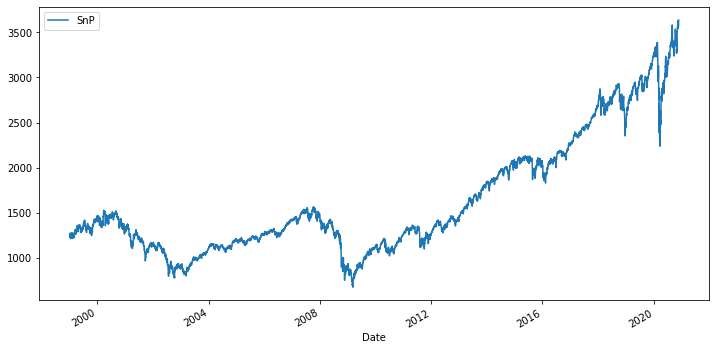

In [39]:
prices = data[['Adj Close']].dropna()
prices.columns = ['SnP']
prices['1999':].plot(figsize=(12,6))
plt.show()

In [40]:
px_monthly = prices.resample('M').fillna('ffill')
px_monthly.index = px_monthly.index.to_period('M')
rets_monthly = px_monthly.pct_change().dropna()
risky_r = rets_monthly

In [41]:
erk.summary_stats(risky_r)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
SnP,0.059008,0.186555,0.128286,10.945787,0.071688,0.122842,0.151101,-0.860296


## Interactive Plots
### Generating Geometric Brownian Motion of the Risky Asset

#### Parameters
- **n_scenarios**: Number of scenarios to simulate
- **n_years**: Number of years forward per scenario
- **steps_per_year**: Number of steps per year
- **mu**: Expected return
- **sigma**: Volatility
- **s_0**: Initial investment amount

#### Output
- Simulated investment amount

Adjust the expected return (mu) and volatility (sigma) to be close to that observed above on the risky asset.

In [19]:
def show_gbm(n_scenarios, mu, sigma):
    s_0 = 100
    n_years = 10
    steps_per_year = 12

    prices = erk.gbm(n_years=n_years, n_scenarios=n_scenarios, mu=mu, sigma= sigma, 
                     steps_per_year=steps_per_year, s_0=s_0)
    ax = prices.plot(legend=False, color='indianred', alpha=0.5, linewidth=2, figsize=(12,5))
    ax.axhline(y=s_0, ls=":", color='black')
#     ax.set_ylim(top=400)
    ax.plot(0, s_0, marker='o', color='darkred', alpha=0.2)
    
gbm_controls = widgets.interactive(show_gbm, 
                                   n_scenarios = (1,50,1),
                                   mu = (-0.2,0.2,0.01),
                                   sigma = (0, .3, .01)
                                  )

display(gbm_controls)

interactive(children=(IntSlider(value=50, description='n_scenarios', min=1), FloatSlider(value=0.0, descriptio…

## Incorporating the simulated risky asset investment value to the CPPI strategy

In [50]:
### PLOT
def show_cppi(n_scenarios=50, mu=0.07, sigma=0.15, m=3, floor=0., riskfree_rate=0.03, y_max=100):
    """
    Plot the results of a Monte Carlo Simulation of CPPI
    """
    start=100
    sim_rets = erk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, prices=False, steps_per_year=12)
    risky_r = pd.DataFrame(sim_rets)
    btr = erk.run_cppi(risky_r=pd.DataFrame(risky_r), riskfree_rate=riskfree_rate, m=m, start=start, floor=floor)
    wealth = btr['Wealth']
    y_max = wealth.values.max() * y_max/100
    ax = wealth.plot(legend=False, alpha=0.3, color="indianred", figsize=(12,6))
    ax.axhline(y=start, ls=":", color='black')
    ax.axhline(y=start*floor, ls="--", color='red')
    ax.set_ylim(top=y_max)
    
### CONTROLS
cppi_controls = widgets.interactive(
    show_cppi,
    n_scenarios=widgets.IntSlider(min=1, max=1000, step=5, value=50),
    mu=widgets.FloatSlider(min=0, max=0.2, step=0.01, value=0.06, description='return'),
    sigma=widgets.FloatSlider(min=0, max=0.3, step=0.01, value=0.18, description='volatility'),
    floor=(0, 2, .1),
    m=(1, 5, .5),
    riskfree_rate=(0.,.05,.01),
    y_max=widgets.IntSlider(min=0, max=100, step=1, value=100, 
                            description='Zoom Y Axis')
    )

### DISPLAY
display(cppi_controls)

interactive(children=(IntSlider(value=50, description='n_scenarios', max=1000, min=1, step=5), FloatSlider(val…

### Observations

1. By default, there are 50 simulated paths of CPPI investment value, over a period of 10 years with 12 monthly steps.  Expected return mu is positive, then most simulated path ends above 100 at the end of year 10.  Volatility is high and generating a large distribution of terminal value.

2. Adjust the floor upwards from 0.  Observe how the CPPI strategy will protect investment value from dropping below the floor.  Reduce **Zoom Y Axis** to see how the simulated paths avoid falling through the floor.

3. Adjust the m upwards will lead to scenarios with much higher returns.  However, this may also lead to larger dispersion of returns and hence lower sharpe ratios.

4. Adjust the volatility upwards will lead to gap risks.  There will be scenarios that investment value falls through the floor because rebalancing is not frequent enough.  One can minimise gap risk by reducing m.

## Interactive CPPI Simulation with Terminal Value Distribution

- Studying the Termina Value Distribution of simulated paths

In [51]:
### PLOT
def show_cppi(n_scenarios=50, mu=0.07, sigma=0.15, m=3, floor=0., riskfree_rate=0.03, y_max=100):
    """
    Plot the results of a Monte Carlo Simulation of CPPI
    """
    start=100
    sim_rets = erk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, prices=False, steps_per_year=12)
    risky_r = pd.DataFrame(sim_rets)
    btr = erk.run_cppi(risky_r=pd.DataFrame(risky_r), riskfree_rate=riskfree_rate, m=m, start=start, floor=floor)
    wealth = btr['Wealth']
    y_max = wealth.values.max() * y_max/100

    terminal_wealth = wealth.iloc[-1]
    
    fig, (wealth_ax, hist_ax) = plt.subplots(nrows=1, ncols=2, sharey=True, 
                                             gridspec_kw={'width_ratios':[3,2]}, figsize=(24,9))
    plt.subplots_adjust(wspace=0.0)
    
    wealth.plot(ax=wealth_ax, legend=False, alpha=0.3, color="indianred")
    wealth_ax.axhline(y=start, ls=":", color='black')
    wealth_ax.axhline(y=start*floor, ls="--", color='red')
    wealth_ax.set_ylim(top=y_max)
    
    terminal_wealth.plot.hist(ax=hist_ax, bins=50, ec='w', fc='indianred', orientation='horizontal')
    hist_ax.axhline(y=start, ls=":", color='black')

### CONTROLS
cppi_controls = widgets.interactive(
    show_cppi,
    n_scenarios=widgets.IntSlider(min=1, max=1000, step=1, value=500),
    mu=widgets.FloatSlider(min=0, max=0.2, step=0.01, value=0.06, 
                           description='return'),
    sigma=widgets.FloatSlider(min=0, max=0.3, step=0.01, value=0.18, 
                              description='volatility'),
    floor=(0, 2, .1),
    m=(1, 5, .5),
    riskfree_rate=(0.,.05,.01),
    y_max=widgets.IntSlider(min=0, max=100, step=1, value=100, 
                            description='Zoom Y Axis')
    )

### DISPLAY
display(cppi_controls)

interactive(children=(IntSlider(value=500, description='n_scenarios', max=1000, min=1), FloatSlider(value=0.06…

## Observations

1. By default, the expected return is positive.  Hence most of the simulated paths will end up with terminal value greater than the initial investment amount.  The volatility controls the dispersion of the terminal value.
2. Adjust the floor value to 0.8.  Note how the investment amount did not fall below the floor.  However, the number of positive simulated paths remain stable.  There is no improvement to the upside.
3. Adjust m upward does not really improve the number of positive terminal values.  On the other hand, higher m in a volatile environment may cause some paths to drop below the floor during the investment period and potentially at terminal value.

## Interactive CPPI Simulation with Performance Risk Statistics and Violation Count

In [54]:
### PLOT
def show_cppi(n_scenarios=50, mu=0.07, sigma=0.15, m=3, floor=0., riskfree_rate=0.03, y_max=100):
    """
    Plot the results of a Monte Carlo Simulation of CPPI
    """
    start=100
    sim_rets = erk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, prices=False, steps_per_year=12)
    risky_r = pd.DataFrame(sim_rets)
    btr = erk.run_cppi(risky_r=pd.DataFrame(risky_r), riskfree_rate=riskfree_rate, m=m, start=start, floor=floor)
    wealth = btr['Wealth']
    
    y_max = wealth.values.max() * y_max/100
    terminal_wealth = wealth.iloc[-1]

    tw_mean = terminal_wealth.mean()
    tw_median = terminal_wealth.median()
    failure_mask = np.less(terminal_wealth, start*floor)
    n_failures = failure_mask.sum()
    p_fail = n_failures/n_scenarios
    
    e_shortfall = np.dot(terminal_wealth-start*floor, failure_mask)/n_failures if n_failures > 0 else 0.0
    
    fig, (wealth_ax, hist_ax) = plt.subplots(nrows=1, ncols=2, sharey=True, 
                                             gridspec_kw={'width_ratios':[3,2]}, figsize=(24,9))
    plt.subplots_adjust(wspace=0.0)
    
    wealth.plot(ax=wealth_ax, legend=False, alpha=0.3, color="indianred")
    wealth_ax.axhline(y=start, ls=":", color='black')
    wealth_ax.axhline(y=start*floor, ls="--", color='red')
    wealth_ax.set_ylim(top=y_max)
    
    terminal_wealth.plot.hist(ax=hist_ax, bins=50, ec='w', fc='indianred', orientation='horizontal')
    hist_ax.axhline(y=start, ls=":", color='black')
    hist_ax.axhline(y=tw_mean, ls=":", color='blue')
    hist_ax.axhline(y=tw_median, ls=":", color='purple')
    hist_ax.annotate(f"Mean: ${int(tw_mean)}", xy=(.4,.9), xycoords='axes fraction', fontsize=24)
    hist_ax.annotate(f"Median: ${int(tw_median)}", xy=(.4,.85), xycoords='axes fraction', fontsize=24)
    if (floor > 0.01):
        hist_ax.axhline(y=start*floor, ls="--", color='red', linewidth=3)
        hist_ax.annotate(f"Violations: {n_failures} ({p_fail*100:2.2f}%)\nE(shortfall)=${e_shortfall:2.2f}", 
                         xy=(.4, .7), xycoords='axes fraction', fontsize=24)

### CONTROLS        
cppi_controls = widgets.interactive(
    show_cppi, 
    n_scenarios=widgets.IntSlider(min=1, max=1000, step=1, value=500),
    mu=widgets.FloatSlider(min=0, max=0.2, step=0.01, value=0.06, 
                           description='return'),
    sigma=widgets.FloatSlider(min=0, max=0.3, step=0.01, value=0.18, 
                              description='volatility'),
    floor=(0, 2, .1),
    m=(1, 5, .5),
    riskfree_rate=(0.,.05,.01),
    y_max=widgets.IntSlider(min=0, max=100, step=1, value=100, description='Zoom Y Axis')
)

### DISPLAY
display(cppi_controls)

interactive(children=(IntSlider(value=500, description='n_scenarios', max=1000, min=1), FloatSlider(value=0.06…

## Observations

1. Increasing the m does not change the mean and median of the terminal value significantly.
2. Violations (terminal value below the floor) occurs when m and volatility is high enough.  Even then the expected shortfall is relatively small.
3. The multiplier m should be calibrated to minimise gap risk based on portfolio volatility estimate and be flexible in making an adjustment under extreme stress market conditions.